# Entity Embeddings with MLJFlux

This demonstration is available as a Jupyter notebook or julia script
[here](https://github.com/FluxML/MLJFlux.jl/tree/dev/docs/src/common_workflows/entity_embeddings).

Entity embedding is newer deep learning approach for categorical encoding introduced in 2016 by Cheng Guo and Felix Berkhahn.
It employs a set of embedding layers to map each categorical feature into a dense continuous vector in a similar fashion to how they are employed in NLP architectures.

In MLJFlux, the `NeuralNetworkClassifier`, `NeuralNetworkRegressor`, and the `MultitargetNeuralNetworkRegressor`` can be trained and evaluated with heterogenous data (i.e., containing categorical features) because they have a built-in entity embedding layer.
Moreover, they now offer a transform which encode the categorical features with the learnt embeddings to be used by an upstream machine learning model.

In this notebook, we will explore how to use entity embeddings in MLJFlux models.

In [1]:
using Pkg
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/Documents/GitHub/MLJFlux.jl/docs/src/common_workflows/entity_embeddings`


**Julia version** is assumed to be 1.10.*

### Basic Imports

In [2]:
using MLJ
using Flux
using Optimisers
using CategoricalArrays
using DataFrames
using Random
using Tables
using ProgressMeter
using Plots
using ScientificTypes

Generate some data

In [3]:
X, y = make_blobs(1000, 2; centers=2, as_table=true, rng=40)
X = DataFrame(X);

Visualize it

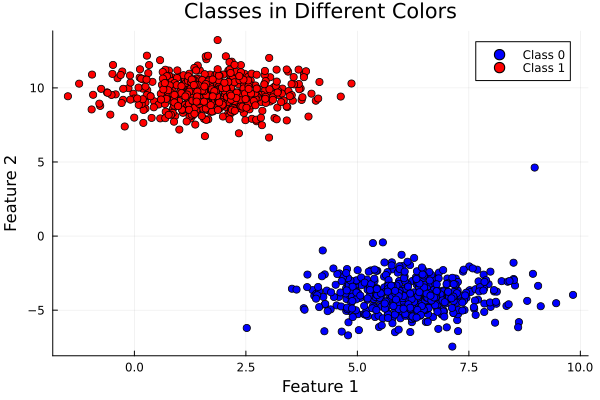

In [4]:
X_class0 = X[y .== 1, :]
X_class1 = X[y .== 2, :]

p = plot()

scatter!(p, X_class0[!, 1], X_class0[!, 2], markercolor=:blue, label="Class 0")
scatter!(p, X_class1[!, 1], X_class1[!, 2], markercolor=:red, label="Class 1")

title!(p, "Classes in Different Colors")
xlabel!("Feature 1")
ylabel!("Feature 2")

plot(p)

Let's write a function that creates categorical features C1 and C2 from x1 and x2 in a meaningful way:

In [5]:
Random.seed!(40)
generate_C1(x1) = (x1 > mean(X.x1) ) ? rand(['A', 'B'])  : rand(['C', 'D'])
generate_C2(x2) = (x2 > mean(X.x2) ) ? rand(['X', 'Y'])  : rand(['Z'])

generate_C2 (generic function with 1 method)

Generate C1 and C2 columns

In [6]:
X[!, :C1] = [generate_C1(x) for x in X[!, :x1]]
X[!, :C2] = [generate_C2(x) for x in X[!, :x2]]
X[!, :R3] = rand(1000);  # A random continuous column.

Form final dataset using categorical and continuous columns

In [7]:
X = X[!, [:C1, :C2, :R3]];

It's also necessary to cast the categorical columns to the correct scientific type as the embedding layer
will have an effect on the model if and only if categorical columns exist.

In [8]:
X = coerce(X, :C1 =>Multiclass, :C2 =>Multiclass);

Split the data

In [9]:
(X_train, X_test), (y_train, y_test) = partition(
	(X, y),
	0.8,
	multi = true,
	shuffle = true,
	stratify = y,
	rng = Random.Xoshiro(41)
);

### Build MLJFlux Model

In [10]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg = MLJFlux


clf = MLJFlux.NeuralNetworkBinaryClassifier(
    builder = MLJFlux.Short(n_hidden = 5),
    optimiser = Optimisers.Adam(0.01),
    batch_size = 2,
    epochs = 100,
    acceleration = CUDALibs(),
    embedding_dims =  Dict(:C1 => 2, :C2 => 2,),
);

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔
┌ Info: The CUDA functionality is being called but
│ `CUDA.jl` must be loaded to access it.
└ Add `using CUDA` or `import CUDA` to your code.  Alternatively, configure a different GPU backend by calling `Flux.gpu_backend!`.
┌ Warning: `acceleration isa CUDALibs` but no CUDA device (GPU) currently live. 
└ @ MLJFlux ~/.julia/packages/MLJFlux/AO4Dh/src/types.jl:62


Notice that we specified to embed each of the columns to 2D columns. By default, it uses `min(numfeats - 1, 10)`
for the new dimensionality of any categorical feature.

### Train and evaluate

In [11]:
mach = machine(clf, X_train, y_train)

fit!(mach, verbosity = 0)

┌ Info: The CUDA functionality is being called but
│ `CUDA.jl` must be loaded to access it.
└ Add `using CUDA` or `import CUDA` to your code.  Alternatively, configure a different GPU backend by calling `Flux.gpu_backend!`.
┌ Warning: `acceleration isa CUDALibs` but no CUDA device (GPU) currently live. 
└ @ MLJBase ~/.julia/packages/MLJBase/7nGJF/src/machines.jl:654


trained Machine; caches model-specific representations of data
  model: NeuralNetworkBinaryClassifier(builder = Short(n_hidden = 5, …), …)
  args: 
    1:	Source @941 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{4}}, AbstractVector{Multiclass{3}}}}
    2:	Source @035 ⏎ AbstractVector{Multiclass{2}}


Get predictions on the training data

In [12]:
y_pred = predict_mode(mach, X_test)
balanced_accuracy(y_pred, y_test)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(5 => 5, σ)    # 30 parameters
│   summary(x) = "5×200 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/htpCe/src/layers/stateless.jl:59


1.0

Notice how the model has learnt to almost perfectly distinguish the classes and all the information
has been in the categorical variables.

### Visualize the embedding space

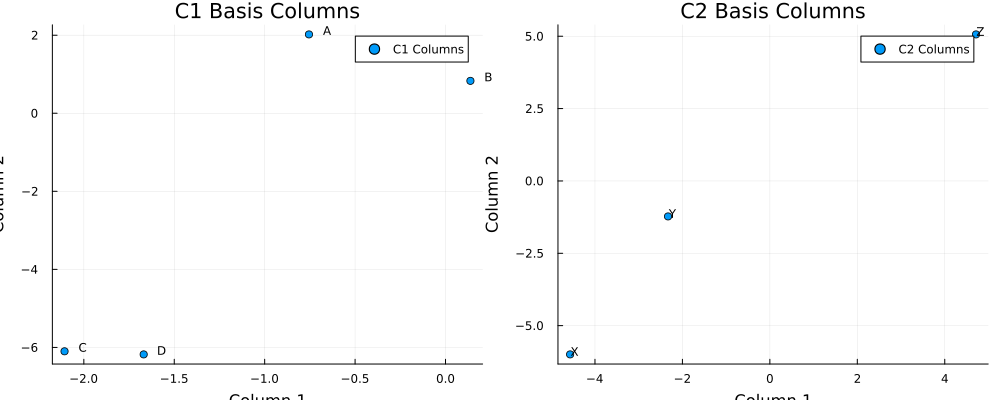

In [13]:
mapping_matrices = MLJFlux.get_embedding_matrices(
                fitted_params(mach).chain,
                [1, 2],             # feature indices
                [:C1, :C2],         # feature names (to assign to the indices)
            )

C1_basis = mapping_matrices[:C1]
C2_basis = mapping_matrices[:C2]

p1 = scatter(C1_basis[1, :], C1_basis[2, :],
             title = "C1 Basis Columns",
             xlabel = "Column 1",
             ylabel = "Column 2",
             label = "C1 Columns",
             legend = :topright)

p2 = scatter(C2_basis[1, :], C2_basis[2, :],
             title = "C2 Basis Columns",
             xlabel = "Column 1",
             ylabel = "Column 2",
             label = "C2 Columns",
             legend = :topright)

c1_cats = ['A', 'B', 'C', 'D']
for (i, col) in enumerate(eachcol(C1_basis))
    annotate!(p1, col[1] + 0.1, col[2] + 0.1, text(c1_cats[i], :black, 8))
end

c2_cats = ['X', 'Y', 'Z']
for (i, col) in enumerate(eachcol(C2_basis))
    annotate!(p2, col[1] + 0.1, col[2] + 0.1, text(string(c2_cats[i]), :black, 8))
end

plot(p1, p2, layout = (1, 2), size = (1000, 400))

As we can see, categories that were generated in a similar pattern were assigned similar vectors. In a dataset,
where some columns have high cardinality, it's expected that some of the categories will exhibit similar patterns.

### Transform (embed) data

In [14]:
X_tr = MLJ.transform(mach, X);

This will transform each categorical value into its corresponding embedding vector. Continuous value will remain intact.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*